In [ ]:
import matplotlib.pyplot as pplt
import plotly.graph_objects as go
import theano.tensor as tt
import scipy as sc
import pymc3 as pm
import math as math
import numpy as np
import pandas as pd
import descartes

In [ ]:
# making dict of state populations
statePops = {'AK': 731545, 'AL': 4903185, 'AR': 3017804, 'AS': 49437, 'AZ': 7278717,
             'CA': 39512223, 'CO': 5758736, 'CT': 3565287, 'DC': 705749, 'DE': 973764,
             'FL': 21477737, 'GA': 10617423, 'GU': 168485, 'HI': 1415872, 'IA': 3155070,
             'ID': 1787065, 'IL': 12671821, 'IN': 6732219, 'KS': 2913314, 'KY': 4467673,
             'LA': 4648794, 'MA': 6892503, 'MD': 6045680, 'ME': 1344212, 'MI': 9986857,
             'MN': 5639632, 'MO': 6137428, 'MP': 51433, 'MS': 2976149, 'MT': 1068778,
             'NC': 10488084, 'ND': 762062, 'NE': 1934408, 'NH': 1359711, 'NJ': 8882190,
             'NM': 2096829, 'NV': 3080156, 'NY': 19453561, 'OH': 11689100, 'OK': 3956971,
             'OR': 4217737, 'PA': 12801989, 'PR': 3193694, 'RI': 1059361, 'SC': 5148714,
             'SD': 884659, 'TN': 6829174, 'TX': 28995881, 'UT': 3205958, 'VA': 8535519,
             'VI': 106235, 'VT': 623989, 'WA': 7614893, 'WI': 5822434, 'WV': 1792147,
             'WY': 578759}
    
# this function will attempt to fill in missing data from each state as accurately as possible
def fill_na(df):
    df = df.sort_values(by=['date'])
    filled_df = []
    
    # loop through table for each state
    for state in np.unique(df.state):
        # subset by state
        this_df = df.loc[df.state == state,]
        # fill NA forward with first good value
        this_df = this_df.fillna(method='ffill')
        # fill NA backward with zero, this ASSUMES deaths were 0 before first set of reported deaths
        this_df.death = this_df.death.fillna(0)
        # appending filled data to filledDf
        filled_df.append(this_df)

    # concatenating filledDf into dataframe
    filled_df = pd.concat(filled_df)

    return filled_df

# this function will take in a csv and a name and return a dataframe with that name
def load_us_df(file):
    df = pd.read_csv(file)
    df = df[['date','state','positive','negative','recovered','death','hospitalized','total']]
    df = fill_na(df)
    df['date'] = df['date'].apply(lambda d: str(d)[0:4] + '-' + str(d)[4:6] + '-' + str(d)[6:8])
    
    return df

# URL of data
historicalStatesURL = 'https://covidtracking.com/api/v1/states/daily.csv'
# loading data
stateData = load_us_df(historicalStatesURL)
stateData = stateData[~stateData.state.isin(["AS","DC","GU","MP","PR","VI"])]

stateData

date state  positive  ...  death  hospitalized   total
20451  2020-03-06    AK       NaN  ...    0.0           NaN       1
20400  2020-03-07    AK       NaN  ...    0.0           NaN       2
20349  2020-03-08    AK       NaN  ...    0.0           NaN       6
20298  2020-03-09    AK       NaN  ...    0.0           1.0       9
20247  2020-03-10    AK       NaN  ...    0.0           1.0       9
...           ...   ...       ...  ...    ...           ...     ...
279    2021-03-03    WY   54616.0  ...  682.0        1388.0  236297
223    2021-03-04    WY   54685.0  ...  682.0        1389.0  236642
167    2021-03-05    WY   54764.0  ...  682.0        1391.0  237028
111    2021-03-06    WY   54764.0  ...  682.0        1391.0  237028
55     2021-03-07    WY   54764.0  ...  682.0        1391.0  237028

[18627 rows x 8 columns]

In [ ]:
# here, start is a parameter that will indicate which of 3 sets of starting values to work with
def sampleMCMC(data, pop, start):

    # splitting data into infections and time as numpy arrays
    dataDeath = data['death'].to_numpy()
    time = np.linspace(0,len(data)-1, len(data))

    # establishing model
    with pm.Model() as model:
        
        # create population number priors
        i0 = pm.Poisson('i0', mu=pop/1000)
        s0 = pm.Deterministic('s0', pop - i0)
        
        # extract starting components
        pos = float(data['positive'].iloc[-1])
        rec = float(data['recovered'].iloc[-1])
        dea = float(data['death'].iloc[-1])
        tot = float(data['total'].iloc[-1])
        
        # create starting values based on data, does not inform inference but starts at a reasonable value
        # start beta conditional on start argument
        beta_start = (
            ((pos/tot)/2 if start==1 else
            (pos/tot + pos/pop)/2 if start == 2 else
            (pos/tot)) if (not(math.isnan(pos)) and not(math.isnan(tot))) else .05)
        
        # start gamma conditional on start argument
        gamma_start = (
            ((rec/tot)/2 if start==1 else
            (rec/tot + rec/pop)/2 if start==2 else
            (rec/tot)) if (not(math.isnan(rec)) and not(math.isnan(tot))) else .047)
        
        # start rho conditional on start argument
        rho_start = (
            ((dea/pos)/2 if start==1 else
            (dea/pos + dea/pop)/2 if start==2 else
            (dea/pos)) if (not(math.isnan(dea)) and not(math.isnan(pos))) else .036)
        
        # creating priors for beta, gamma, and rho
        beta = pm.InverseGamma('beta', mu=.05, sigma=.5, testval=beta_start)
        gamma = pm.InverseGamma('gamma', mu=.047, sigma=.5, testval=gamma_start)
        rho = pm.TruncatedNormal('rho', mu=.036, sigma=.01, lower=0, upper=1, testval=rho_start)

        # create number of removed based on analytic solution and above parameters
        sirRem = pm.Deterministic('sirRem',
            pop - ((s0 + i0)**(beta/(beta - gamma)))*
            (s0 + i0*tt.exp(time*(beta - gamma)))**(-gamma/(beta - gamma)))
        # create number of deaths as a fraction of number of removed
        sirDeath = pm.Deterministic('sirDeath', rho*sirRem)
        
        # create variance prior
        sigma = pm.HalfCauchy('sigma', beta=2)
        
        # create likelihood with modelled counts and observed counts
        obsDeath = pm.TruncatedNormal('obsDeath', mu=sirDeath, sigma=sigma,
                                     lower=0, upper=pop, observed=dataDeath)

        # specifying model conditions
        step=pm.NUTS(target_accept=.99)
        start=pm.find_MAP()
        
        # execute sampling
        model_trace = pm.sample(draws=500, tune=500, step=step, start=start, chains=5, cores=16)

    # return posterior samples and other information
    return model_trace

'AK:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1892 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will retu

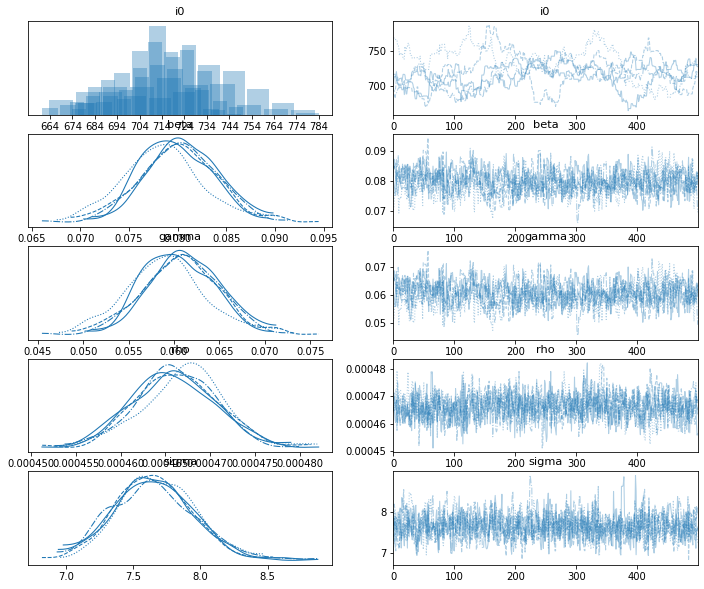

'summary:'

'======================================================================================================='

param       mean        sd     hdi_3%  ...    ess_bulk    ess_tail    r_hat  state
0     i0  719.00600  21.48378  676.00000  ...    28.00940    86.91096  1.14972     AK
1   beta    0.07983   0.00394    0.07269  ...   114.43694   590.99619  1.03837     AK
2  gamma    0.06046   0.00422    0.05277  ...   138.43193   629.66478  1.03404     AK
3    rho    0.00047   0.00000    0.00046  ...   407.60646  1108.15659  1.01003     AK
4  sigma    7.65712   0.29597    7.11465  ...  1263.14245  1199.39978  1.00374     AK

[5 rows x 11 columns]

'AK succeeded'

'======================================================================================================='

'AL:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1442 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

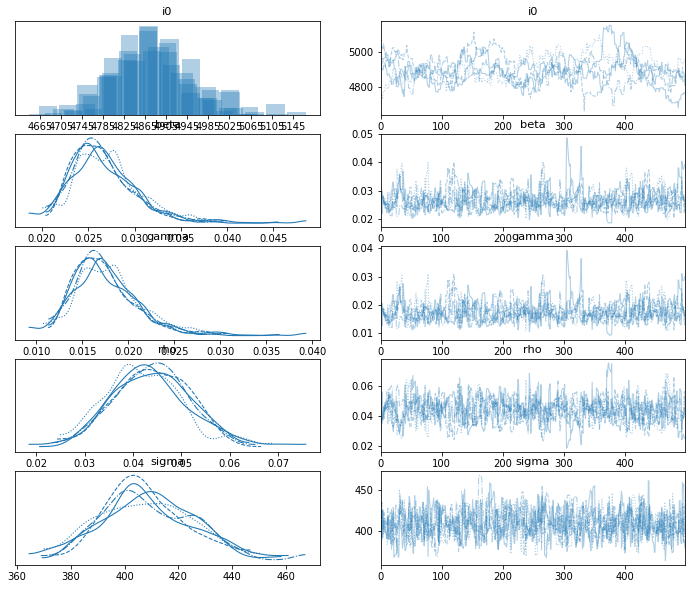

'summary:'

'======================================================================================================='

param        mean        sd      hdi_3%  ...   ess_bulk   ess_tail    r_hat  state
0     i0  4897.33280  73.46399  4770.00000  ...   72.27235  125.44000  1.10526     AL
1   beta     0.02672   0.00354     0.02110  ...  454.12239  470.04787  1.00834     AL
2  gamma     0.01760   0.00354     0.01197  ...  453.45592  476.15860  1.00835     AL
3    rho     0.04361   0.00813     0.02924  ...  474.73682  483.00641  1.00948     AL
4  sigma   408.48596  16.78314   379.02519  ...  774.84330  772.09057  1.00615     AL

[5 rows x 11 columns]

'AL succeeded'

'======================================================================================================='

'AR:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 2116 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9550746278838649, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9707838699938515, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some para

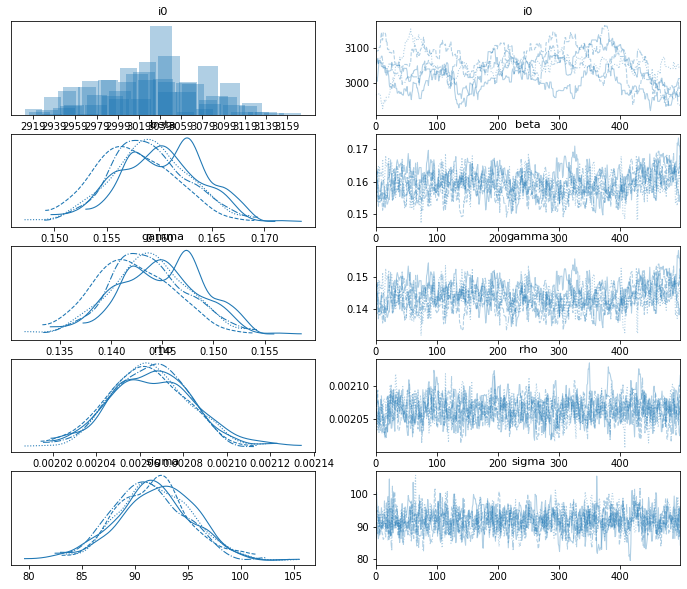

'summary:'

'======================================================================================================='

param        mean        sd      hdi_3%  ...   ess_bulk   ess_tail    r_hat  state
0     i0  3040.22600  45.87684  2950.00000  ...   20.29523   84.43220  1.17932     AR
1   beta     0.15931   0.00397     0.15227  ...   65.56677  340.73847  1.05435     AR
2  gamma     0.14391   0.00408     0.13664  ...   70.81834  370.37042  1.05166     AR
3    rho     0.00206   0.00002     0.00203  ...  552.43563  657.38987  1.01549     AR
4  sigma    91.80036   3.50163    85.45790  ...  725.26144  884.13090  1.01618     AR

[5 rows x 11 columns]

'AR succeeded'

'======================================================================================================='

'AZ:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1719 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

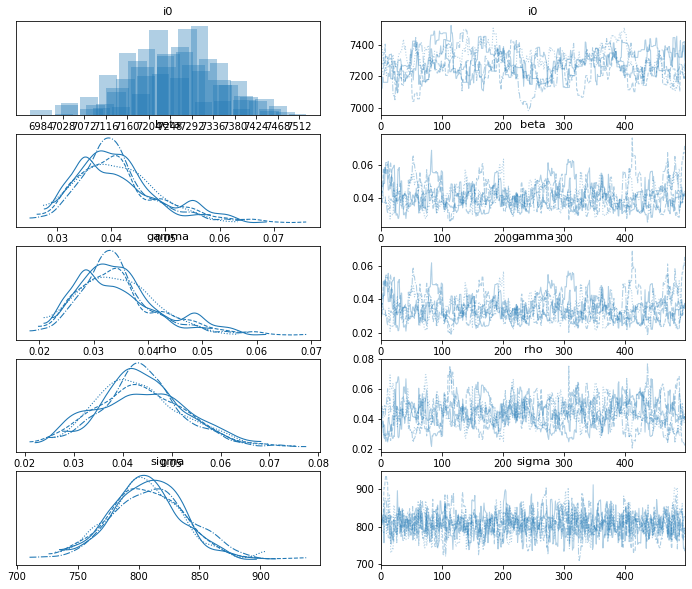

'summary:'

'======================================================================================================='

param        mean        sd      hdi_3%  ...   ess_bulk   ess_tail    r_hat  state
0     i0  7277.61440  87.65491  7128.00000  ...   47.81184  158.26724  1.08977     AZ
1   beta     0.04105   0.00735     0.02966  ...  219.16437  372.37135  1.02125     AZ
2  gamma     0.03440   0.00734     0.02304  ...  220.05444  369.86500  1.02123     AZ
3    rho     0.04402   0.00888     0.02800  ...  225.62804  383.59492  1.02269     AZ
4  sigma   807.79431  31.32098   753.46344  ...  791.13978  813.13422  1.00726     AZ

[5 rows x 11 columns]

'AZ succeeded'

'======================================================================================================='

'CA:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 333 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context 

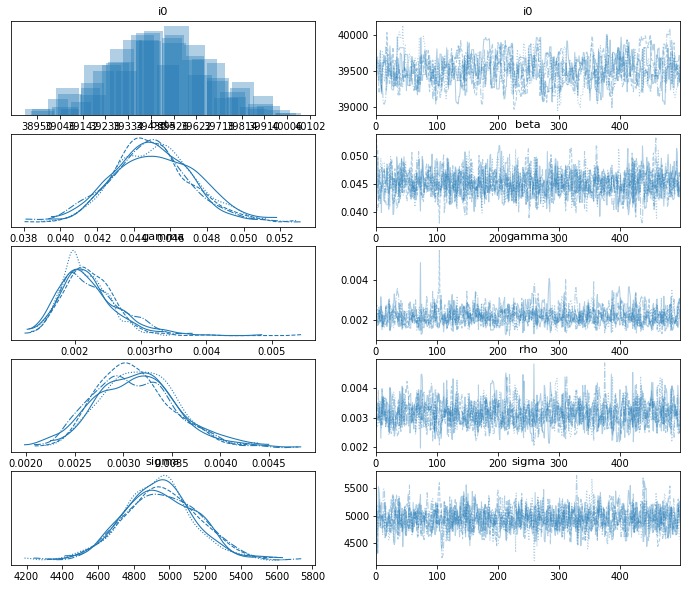

'summary:'

'======================================================================================================='

param         mean         sd  ...    ess_tail    r_hat  state
0     i0  39517.66720  199.99137  ...   388.62608  1.01040     CA
1   beta      0.04507    0.00220  ...  1261.36383  1.00452     CA
2  gamma      0.00220    0.00042  ...   695.20780  1.00700     CA
3    rho      0.00314    0.00041  ...  1034.10239  1.00440     CA
4  sigma   4948.80589  204.41573  ...  1334.86326  1.00273     CA

[5 rows x 11 columns]

'CA succeeded'

'======================================================================================================='

'CO:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1542 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will retu

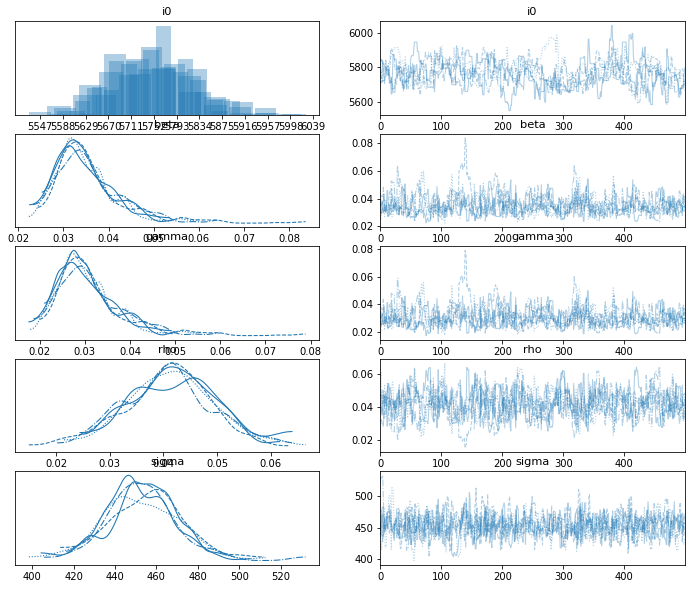

'summary:'

'======================================================================================================='

param        mean        sd      hdi_3%  ...   ess_bulk   ess_tail    r_hat  state
0     i0  5768.95240  72.24731  5640.00000  ...  125.88321  248.84026  1.04857     CO
1   beta     0.03503   0.00686     0.02406  ...  345.35765  365.73148  1.00681     CO
2  gamma     0.03062   0.00686     0.01951  ...  346.97732  356.88539  1.00707     CO
3    rho     0.04156   0.00823     0.02595  ...  348.90233  375.68729  1.00941     CO
4  sigma   453.28534  17.47019   421.75136  ...  755.76299  780.23892  1.00527     CO

[5 rows x 11 columns]

'CO succeeded'

'======================================================================================================='

'CT:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 278 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context 

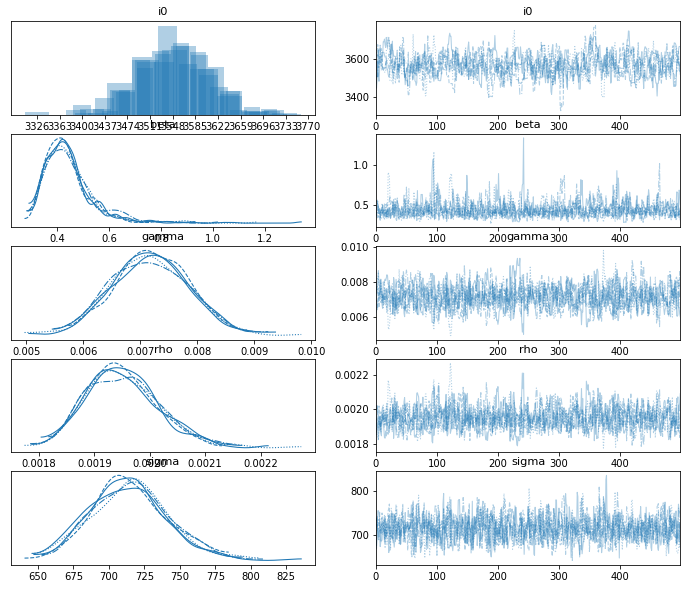

'summary:'

'======================================================================================================='

param        mean        sd  ...    ess_tail    r_hat  state
0     i0  3566.73720  59.70533  ...   609.15067  1.01013     CT
1   beta     0.44292   0.09579  ...   858.79868  1.00260     CT
2  gamma     0.00718   0.00067  ...   892.84182  1.00350     CT
3    rho     0.00195   0.00007  ...   922.35880  1.00293     CT
4  sigma   714.39419  27.03948  ...  1353.02711  1.00259     CT

[5 rows x 11 columns]

'CT succeeded'

'======================================================================================================='

'DE:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 419 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the mode

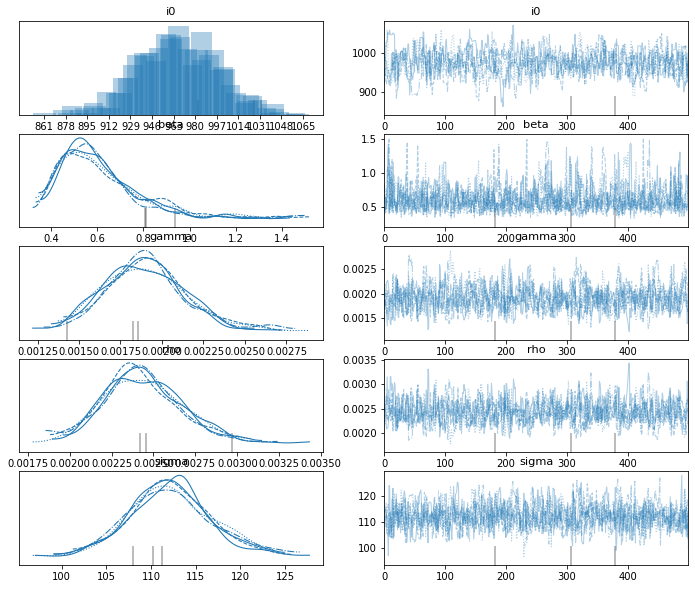

'summary:'

'======================================================================================================='

param       mean        sd     hdi_3%  ...    ess_bulk   ess_tail    r_hat  state
0     i0  974.85480  31.69703  915.00000  ...   435.01172  496.66507  1.01225     DE
1   beta    0.61373   0.18656    0.35101  ...  1084.52552  891.22555  1.00568     DE
2  gamma    0.00190   0.00025    0.00146  ...   758.19571  875.71693  1.00562     DE
3    rho    0.00244   0.00023    0.00203  ...   785.74452  961.19343  1.00565     DE
4  sigma  112.20498   4.52086  103.48285  ...  1037.15039  931.42156  1.00184     DE

[5 rows x 11 columns]

'DE succeeded'

'======================================================================================================='

'FL:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1920 seconds.
There were 373 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9412220962471072, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.849955320639704, but should be close to 0.99. Try to increase the number of tunin

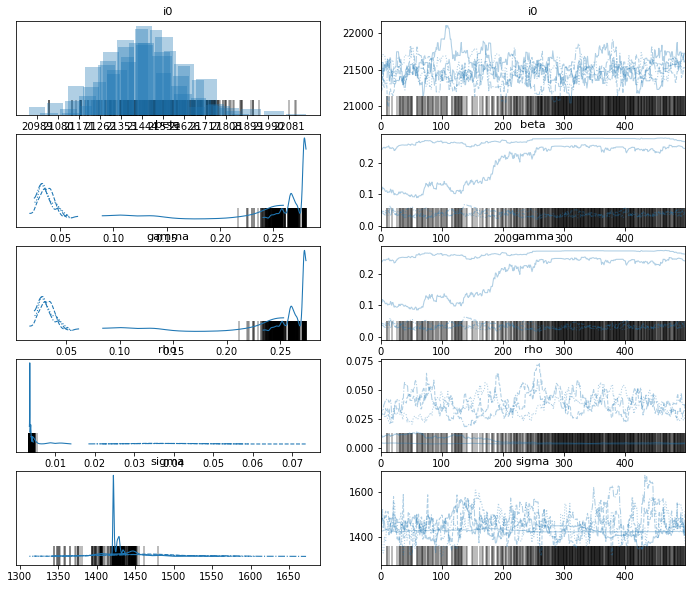

'FL failed'

'======================================================================================================='

'GA:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 522 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context 

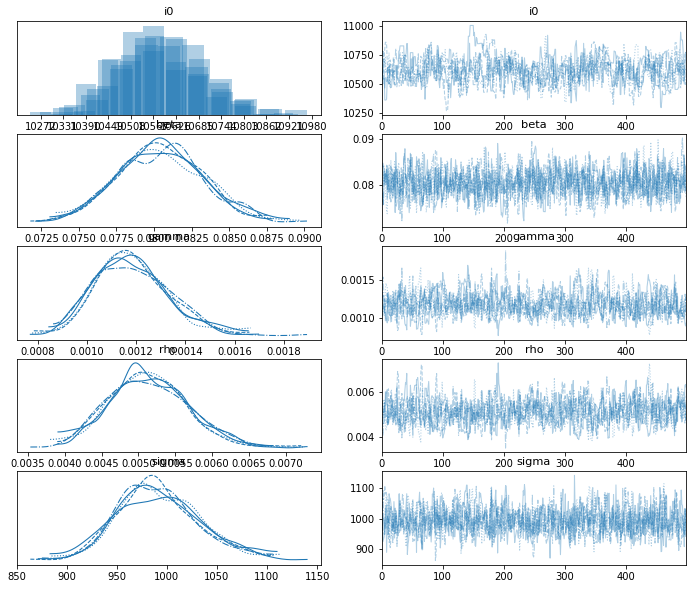

'summary:'

'======================================================================================================='

param         mean         sd  ...    ess_tail    r_hat  state
0     i0  10614.51040  109.51437  ...   279.86983  1.02151     GA
1   beta      0.08043    0.00286  ...  1449.66649  1.00377     GA
2  gamma      0.00118    0.00015  ...   637.46496  1.00244     GA
3    rho      0.00514    0.00053  ...   646.76588  1.00256     GA
4  sigma    992.12730   41.15898  ...  1382.34764  1.00375     GA

[5 rows x 11 columns]

'GA succeeded'

'======================================================================================================='

'HI:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 2312 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will retu

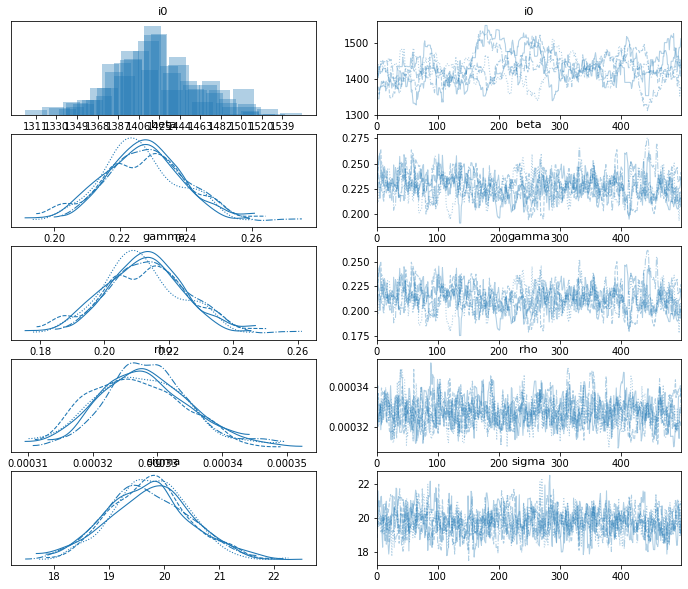

'summary:'

'======================================================================================================='

param        mean        sd      hdi_3%  ...   ess_bulk   ess_tail    r_hat  state
0     i0  1429.70000  39.12440  1357.00000  ...   76.31596  116.94040  1.02908     HI
1   beta     0.22759   0.01260     0.20370  ...  199.67140  320.15335  1.02480     HI
2  gamma     0.21292   0.01290     0.18820  ...  205.30797  321.58612  1.02454     HI
3    rho     0.00033   0.00001     0.00031  ...  516.11588  649.18604  1.00754     HI
4  sigma    19.73696   0.74434    18.36548  ...  592.92112  824.07795  1.01010     HI

[5 rows x 11 columns]

'HI succeeded'

'======================================================================================================='

'IA:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



'IA failed'

'======================================================================================================='

'ID:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/pymc3/distributions/transforms.py:221: RuntimeWarning:

divide by zero encountered in log



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 2097 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

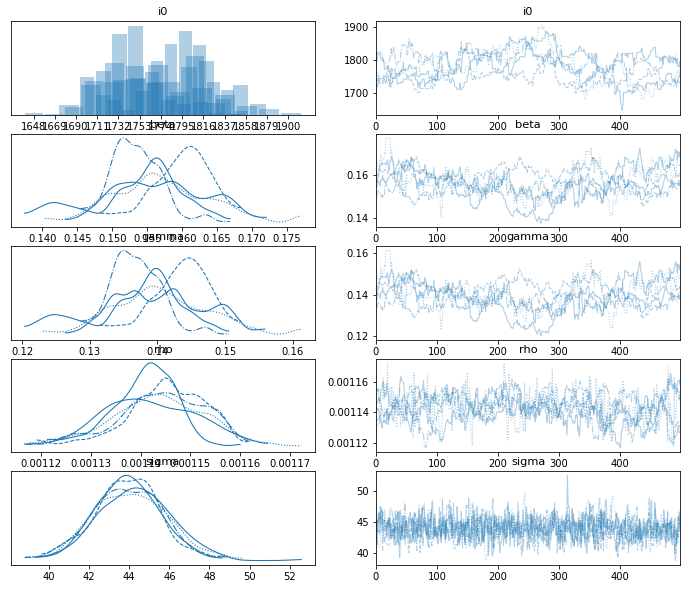

'ID failed'

'======================================================================================================='

'IL:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 451 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context 

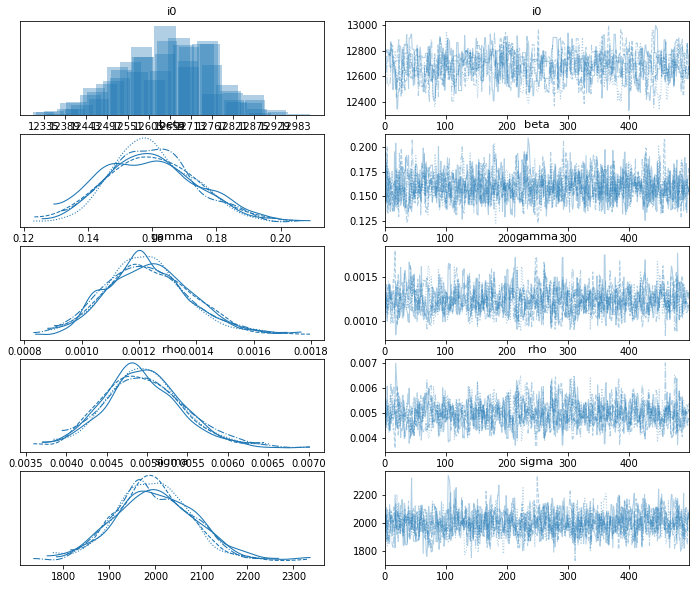

'summary:'

'======================================================================================================='

param         mean         sd  ...    ess_tail    r_hat  state
0     i0  12679.97400  111.54539  ...   726.53800  1.01740     IL
1   beta      0.16011    0.01409  ...  1114.31575  1.00482     IL
2  gamma      0.00123    0.00015  ...  1198.73597  1.00534     IL
3    rho      0.00496    0.00049  ...  1058.18750  1.00416     IL
4  sigma   1996.72128   82.25993  ...  1292.24628  1.00352     IL

[5 rows x 11 columns]

'IL succeeded'

'======================================================================================================='

'IN:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1795 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

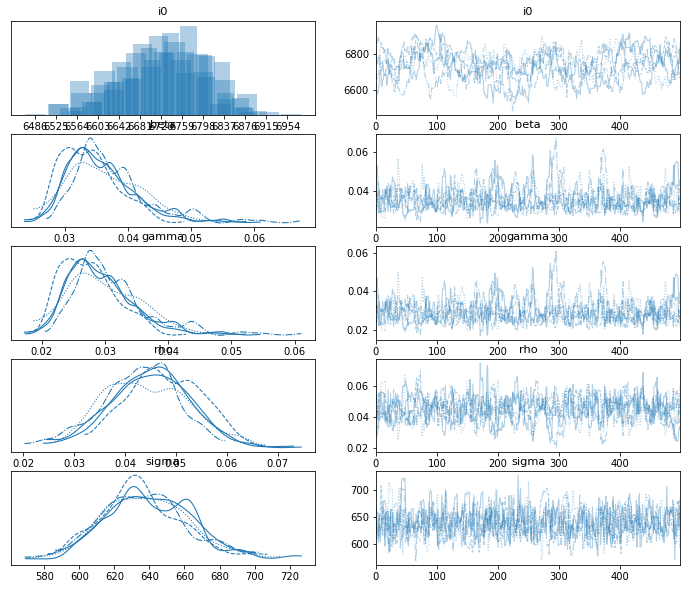

'summary:'

'======================================================================================================='

param        mean        sd      hdi_3%  ...   ess_bulk   ess_tail    r_hat  state
0     i0  6739.30320  78.18154  6591.00000  ...   82.49753  105.31002  1.05096     IN
1   beta     0.03591   0.00574     0.02737  ...  285.38943  383.16725  1.03198     IN
2  gamma     0.02952   0.00574     0.02015  ...  286.70611  381.39289  1.03176     IN
3    rho     0.04501   0.00792     0.03006  ...  291.39950  367.40797  1.03052     IN
4  sigma   638.50017  24.59383   590.81907  ...  628.64207  575.21729  1.00834     IN

[5 rows x 11 columns]

'IN succeeded'

'======================================================================================================='

'KS:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1972 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_

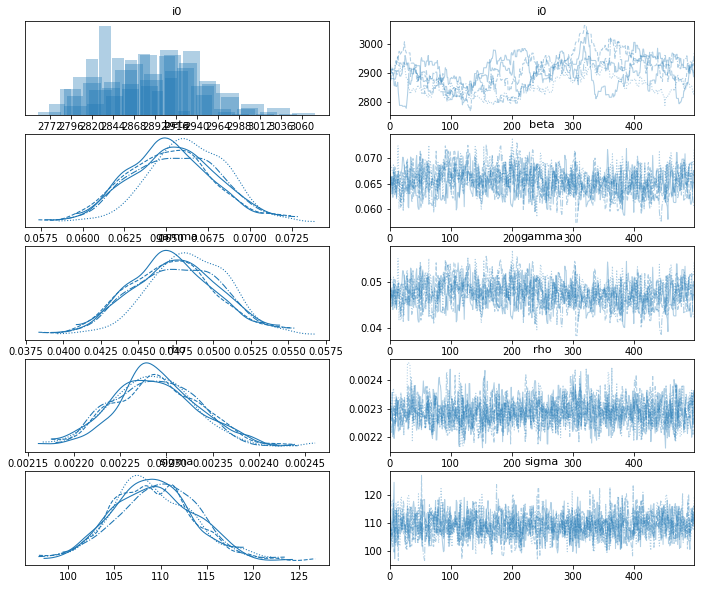

'summary:'

'======================================================================================================='

param        mean        sd  ...    ess_tail    r_hat  state
0     i0  2896.74760  52.21683  ...    68.11121  1.32648     KS
1   beta     0.06554   0.00258  ...   625.12085  1.05484     KS
2  gamma     0.04756   0.00287  ...   724.01643  1.04669     KS
3    rho     0.00229   0.00005  ...  1081.67063  1.00145     KS
4  sigma   109.26773   4.31198  ...  1243.59596  1.00588     KS

[5 rows x 11 columns]

'KS succeeded'

'======================================================================================================='

'KY:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1604 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be de

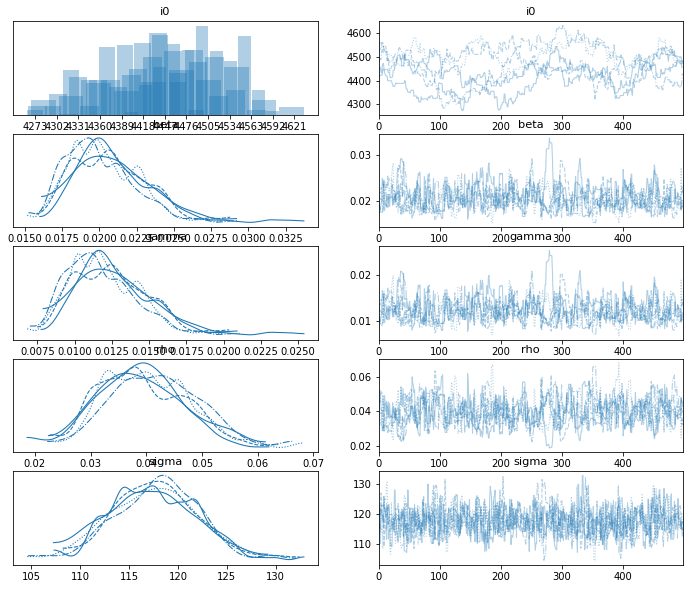

'summary:'

'======================================================================================================='

param        mean        sd      hdi_3%  ...   ess_bulk   ess_tail    r_hat  state
0     i0  4456.58880  70.28374  4321.00000  ...   15.27675   53.24384  1.29321     KY
1   beta     0.02062   0.00257     0.01645  ...  338.35949  468.97236  1.02895     KY
2  gamma     0.01234   0.00256     0.00815  ...  339.03343  464.68573  1.02869     KY
3    rho     0.03990   0.00787     0.02648  ...  348.60453  513.26209  1.02374     KY
4  sigma   117.65816   4.45834   109.68199  ...  855.93274  741.65250  1.00479     KY

[5 rows x 11 columns]

'KY succeeded'

'======================================================================================================='

'LA:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



'LA failed'

'======================================================================================================='

'MA:'

'======================================================================================================='

'MA failed'

'======================================================================================================='

'MD:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 562 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the mode

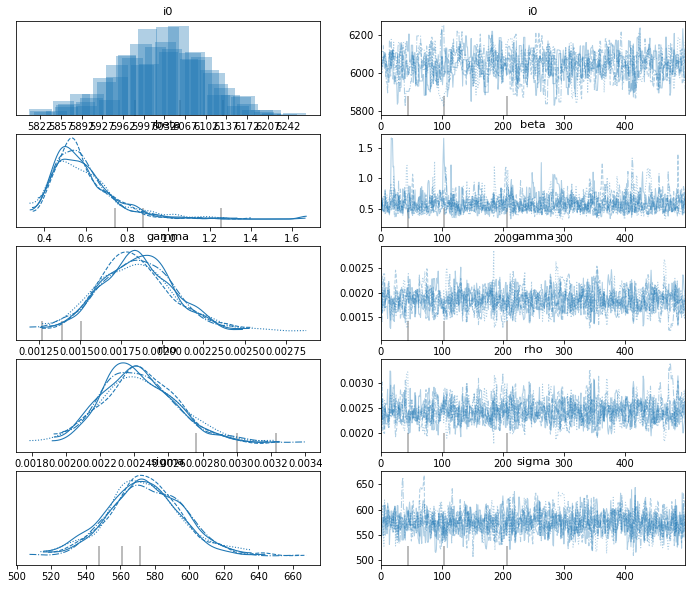

'summary:'

'======================================================================================================='

param        mean        sd  ...   ess_tail    r_hat  state
0     i0  6045.66400  73.08349  ...  483.28327  1.00286     MD
1   beta     0.58745   0.15275  ...  770.28619  1.00868     MD
2  gamma     0.00184   0.00023  ...  793.00099  1.00145     MD
3    rho     0.00244   0.00023  ...  831.50081  1.00174     MD
4  sigma   574.68788  21.68917  ...  879.86814  1.00533     MD

[5 rows x 11 columns]

'MD succeeded'

'======================================================================================================='

'ME:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 1198 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful r

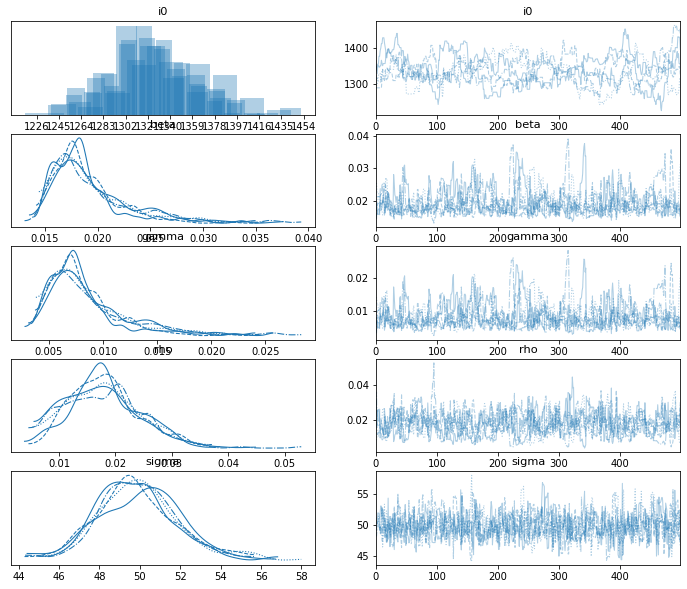

'summary:'

'======================================================================================================='

param        mean        sd      hdi_3%  ...   ess_bulk   ess_tail    r_hat  state
0     i0  1335.01600  36.75556  1267.00000  ...   72.10075  152.83326  1.06567     ME
1   beta     0.01917   0.00370     0.01441  ...  431.87470  439.58010  1.01418     ME
2  gamma     0.00838   0.00363     0.00363  ...  433.29741  431.04430  1.01437     ME
3    rho     0.01789   0.00650     0.00664  ...  437.64825  460.56670  1.00936     ME
4  sigma    49.89785   1.98332    46.10559  ...  805.25520  689.25794  1.00391     ME

[5 rows x 11 columns]

'ME succeeded'

'======================================================================================================='

'MI:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


Sampling 5 chains for 500 tune and 500 draw iterations (2_500 + 2_500 draws total) took 552 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.

Got error No

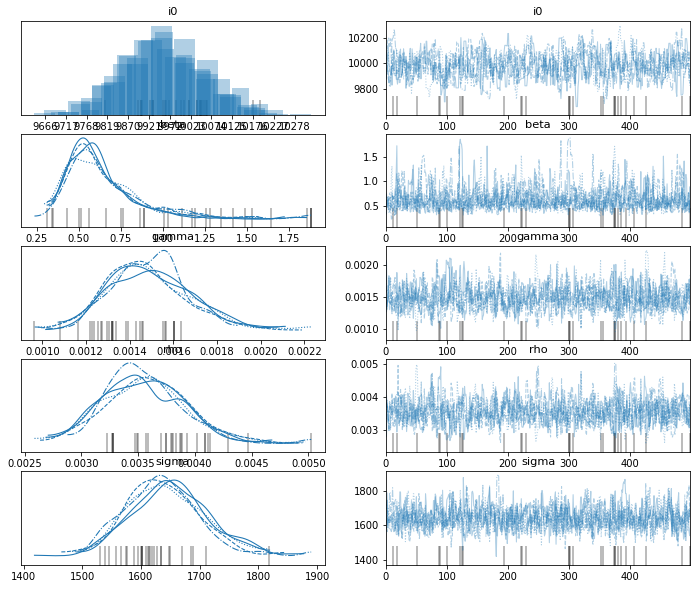

'summary:'

'======================================================================================================='

param        mean        sd  ...    ess_tail    r_hat  state
0     i0  9982.97080  98.82667  ...   541.29210  1.00700     MI
1   beta     0.64125   0.22957  ...   902.10237  1.00570     MI
2  gamma     0.00149   0.00019  ...   835.85640  1.00510     MI
3    rho     0.00356   0.00037  ...   828.06838  1.00441     MI
4  sigma  1643.50573  64.90380  ...  1304.78313  1.00667     MI

[5 rows x 11 columns]

'MI succeeded'

'======================================================================================================='

'MN:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning:

divide by zero encountered in log1p



'MN failed'

'======================================================================================================='

'MO:'

'======================================================================================================='

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


'MO failed'

'======================================================================================================='

'MS:'

'======================================================================================================='

KeyboardInterrupt: ignored

In [ ]:
summary = pd.DataFrame()
trace_results = pd.DataFrame(columns=['state','trace'])

for state in stateData['state'].unique():
    
    display(state + ":")
    display("=======================================================================================================")
                        
    try:
        # perform sampling, first set of starting values
        this_sample = sampleMCMC(stateData.loc[stateData.state == state], statePops[state], 1)
        
    except Exception as e:
        
        try:
            # perform sampling, second set of starting values
            this_sample = sampleMCMC(stateData.loc[stateData.state == state], statePops[state], 2)
            
        except Exception as e:
            
            try:
                # perform sampling, last set of starting values
                this_sample = sampleMCMC(stateData.loc[stateData.state == state], statePops[state], 3)
                
            except Exception as e:
    
                trace_results = trace_results.append({"state":state, "trace":None}, ignore_index=True)
        
                display(state + ' failed')
                display("=======================================================================================================")
                continue
                
    # create summary table
    these_results = (pm.summary(this_sample, var_names=['i0','beta','gamma','rho','sigma'], round_to=5).
        # drop(['mcse_sd','ess_sd','ess_bulk','ess_tail'], axis=1).
        reset_index().rename(columns={"index": "param"}))
    these_results['state'] = state

    # make plots
    plot = pm.plot_trace(this_sample, var_names=('i0','beta','gamma','rho','sigma'))
    pplt.show()
    
    if sum(these_results[1:4]['r_hat']) > 3.15:
        trace_results = trace_results.append({"state":state, "trace":None}, ignore_index=True)
        
        display(state + ' failed')
        display("=======================================================================================================")
        
    else:

        summary = summary.append(these_results)

        # update trace table
        trace_results = trace_results.append({"state":state, "trace":this_sample}, ignore_index=True)

        display('summary:')
        display("=======================================================================================================")

        display(these_results)

        display(state + ' succeeded')
        display("=======================================================================================================")

In [ ]:
fig_beta = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='beta']['state'], # Spatial coordinates
    z = summary[summary['param']=='beta']['mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'YlOrBr',
    colorbar_title = "Transmission Rate per Day",
))

fig_beta.update_layout(
    title_text = 'MCMC Estimates of COVID-19 Transmission Rate by State',
    geo_scope='usa', # limite map scope to USA
)

fig_beta.show()

In [ ]:
fig_gamma = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='gamma']['state'], # Spatial coordinates
    z = summary[summary['param']=='gamma']['mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Removal Rate per Day",
))

fig_gamma.update_layout(
    title_text = 'MCMC Estimates of COVID-19 Removal Rate by State',
    geo_scope='usa', # limite map scope to USA
)

fig_gamma.show()

In [ ]:
fig_rho = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='rho']['state'], # Spatial coordinates
    z = summary[summary['param']=='rho']['mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Mortality Rate per Infection",
))

fig_rho.update_layout(
    title_text = 'MCMC Estimates of COVID-19 Mortality Rate by State',
    geo_scope='usa', # limite map scope to USA
)

fig_rho.show()

In [ ]:
fig_ovrsk = go.Figure(data=go.Choropleth(
    locations = summary[summary['param']=='beta']['state'], # Spatial coordinates
    z = summary[summary['param']=='rho']['mean'].astype(float).to_numpy() * 
        (summary[summary['param']=='beta']['mean'].astype(float).to_numpy() / 
         summary[summary['param']=='gamma']['mean'].astype(float).to_numpy()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Burgyl',
    colorbar_title = "Overall Risk",
))

fig_ovrsk.update_layout(
    title_text = 'Estimated Overall Risk of COVID-19 by State',
    geo_scope='usa', # limite map scope to USA
)

fig_ovrsk.show()